In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
import os
warnings.filterwarnings('ignore')

In [2]:
file_path = r'COMPUSTAT_funda_annual.csv'
df = pd.read_csv(file_path).fillna(0)

df['datadate'] = pd.to_datetime(df['datadate'])

start_date = '1996-01-01'
end_date = '2022-12-31'

df = df[(df['datadate'] >= start_date) & (df['datadate'] <= end_date)]
df.reset_index(inplace=True)
df=df.drop(columns=['index'])

df.head()

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,cusip,conm,...,priusa,sic,spcindcd,spcseccd,spcsrc,state,stko,weburl,dldte,ipodate
0,1004,1996-05-31,1995,INDL,C,D,STD,AIR,000361105,AAR CORP,...,1.0,5080,110.0,925.0,B,IL,0.0,www.aarcorp.com,0,1972-04-24
1,1004,1997-05-31,1996,INDL,C,D,STD,AIR,000361105,AAR CORP,...,1.0,5080,110.0,925.0,B,IL,0.0,www.aarcorp.com,0,1972-04-24
2,1004,1998-05-31,1997,INDL,C,D,STD,AIR,000361105,AAR CORP,...,1.0,5080,110.0,925.0,B,IL,0.0,www.aarcorp.com,0,1972-04-24
3,1004,1999-05-31,1998,INDL,C,D,STD,AIR,000361105,AAR CORP,...,1.0,5080,110.0,925.0,B,IL,0.0,www.aarcorp.com,0,1972-04-24
4,1004,2000-05-31,1999,INDL,C,D,STD,AIR,000361105,AAR CORP,...,1.0,5080,110.0,925.0,B,IL,0.0,www.aarcorp.com,0,1972-04-24


In [3]:
def qualitative_feature_selection(df):
    selected_columns = [
        'datadate',
        'at',      # Total Assets
        'lt',      # Total Liabilities
        'ceq',     # Common Equity
        'revt',    # Revenue
        'cogs',    # Cost of Goods Sold
        'ni',      # Net Income
        'oancf',   # Operating Cash Flow
        'invt',    # Inventory
        'rect',    # Accounts Receivable
        'ap',      # Accounts Payable
        'csho',    # Common Shares Outstanding
        'ebitda',  # Earnings Before Interest, Taxes, Depreciation, and Amortization
        'epsfx',   # Earnings Per Share (Diluted)
        'capx',    # Capital Expenditures
        'dp',      # Depreciation and Amortization
        'gdwl',    # Goodwill
        'dltt',    # Long-Term Debt
        'intan',   # Intangible Assets
        'wcap',    # Working Capital
        'dvp',     # Dividends Payable
        'che',     # Cash and Cash Equivalents
        'mkvalt',  # Market Value of Equity
        'prcc_f',  # Price Close - Fiscal
        'xint',    # Interest Expense
        'xsga'     # Selling, General, and Administrative Expenses
    ]
    
    df_selected = df[selected_columns]
    

    df_selected['debt_to_assets'] = df['lt'] / df['at']
    df_selected['debt_to_equity'] = df['lt'] / df['ceq']
    df_selected['return_on_assets'] = df['ni'] / df['at']
    df_selected['return_on_equity'] = df['ni'] / df['ceq']
    df_selected['current_ratio'] = df['act'] / df['lct']
    df_selected['quick_ratio'] = (df['act'] - df['ivst']) / df['lct']
    df_selected['cash_ratio'] = df['capr1'] / df['lct']
    df_selected['gross_profit_margin'] = (df['revt'] - df['cogs']) / df['revt']
    df_selected['operating_margin'] = (df['revt'] - df['cogs'] - df['xsga']) / df['revt']
    df_selected['ebitda_margin'] = df['ebitda'] / df['revt']
    df_selected['interest_coverage_ratio'] = df['ebit'] / df['xint']
    df_selected['cash_flow_to_debt'] = df['oancf'] / df['lt']
    df_selected['capital_expenditure_ratio'] = df['capx'] / df['at']
    df_selected['long_term_debt_ratio'] = df['dltt'] / df['at']
    df_selected['asset_turnover_ratio'] = df['revt'] / df['at']
    df_selected['working_capital_to_assets'] = df['wcap'] / df['at']
    df_selected['total_investment_to_assets'] = (df['ivst'] + df['ivao']) / df['at']
    df_selected['goodwill_to_assets'] = df['gdwl'] / df['at']
    df_selected['intangible_to_assets'] = df['intan'] / df['at']
    df_selected['deferred_tax_ratio'] = df['txdb'] / df['at']
    
    return df_selected


df_selected = qualitative_feature_selection(df)
df_selected

,datadate,at,lt,ceq,revt,cogs,ni,oancf,invt,rect,...,interest_coverage_ratio,cash_flow_to_debt,capital_expenditure_ratio,long_term_debt_ratio,asset_turnover_ratio,working_capital_to_assets,total_investment_to_assets,goodwill_to_assets,intangible_to_assets,deferred_tax_ratio
0,1996-05-31,437.846,233.211,204.635,504.990,404.110,16.012,24.760,175.084,107.138,...,3.055953,0.106170,0.017237,0.270168,1.153351,0.590680,0.075152,0.013343,0.013343,0.070070
1,1997-05-31,529.584,260.325,269.259,589.328,468.500,23.025,9.531,217.239,122.944,...,3.976451,0.036612,0.057200,0.220584,1.112813,0.593143,0.052128,0.010674,0.010674,0.061482
2,1998-05-31,670.559,369.709,300.850,782.123,619.434,35.657,22.823,263.425,163.359,...,4.465020,0.061732,0.026090,0.264718,1.166375,0.476098,0.091184,0.039616,0.039616,0.054954
3,1999-05-31,726.630,400.595,326.035,918.036,727.714,41.671,28.525,304.499,164.302,...,4.167663,0.071207,0.049724,0.249011,1.263416,0.460482,0.056677,0.055177,0.055177,0.061751
4,2000-05-31,740.998,401.483,339.515,1024.333,833.107,35.163,10.051,336.018,128.348,...,3.015578,0.025035,0.030154,0.243519,1.382369,0.468896,0.057097,0.052416,0.052416,0.075601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296595,2022-12-31,2058.061,1342.548,646.557,212.978,42.103,85.742,118.234,0.991,5.760,...,5.026096,0.088067,0.171767,0.465850,0.103485,-0.064746,0.001669,0.000000,0.004040,0.000000
296596,2021-12-31,46650.099,10793.531,35687.306,12924.885,4445.511,1882.199,1836.160,1287.749,5179.432,...,130.003646,0.170117,0.006618,0.002525,0.277060,0.029404,0.000000,0.239354,0.789382,0.097443
296597,2022-12-31,41948.594,22119.555,19677.222,13082.804,4629.226,1277.194,2485.709,1624.205,2254.368,...,9.519703,0.112376,0.008732,0.287319,0.311877,-0.008933,0.003791,0.241160,0.816774,0.103432
296598,2021-12-31,686.085,379.035,288.849,756.466,377.304,138.508,163.283,154.754,205.966,...,132.691806,0.430786,0.042057,0.029887,1.102583,0.161409,0.000000,0.010179,0.015663,0.023758


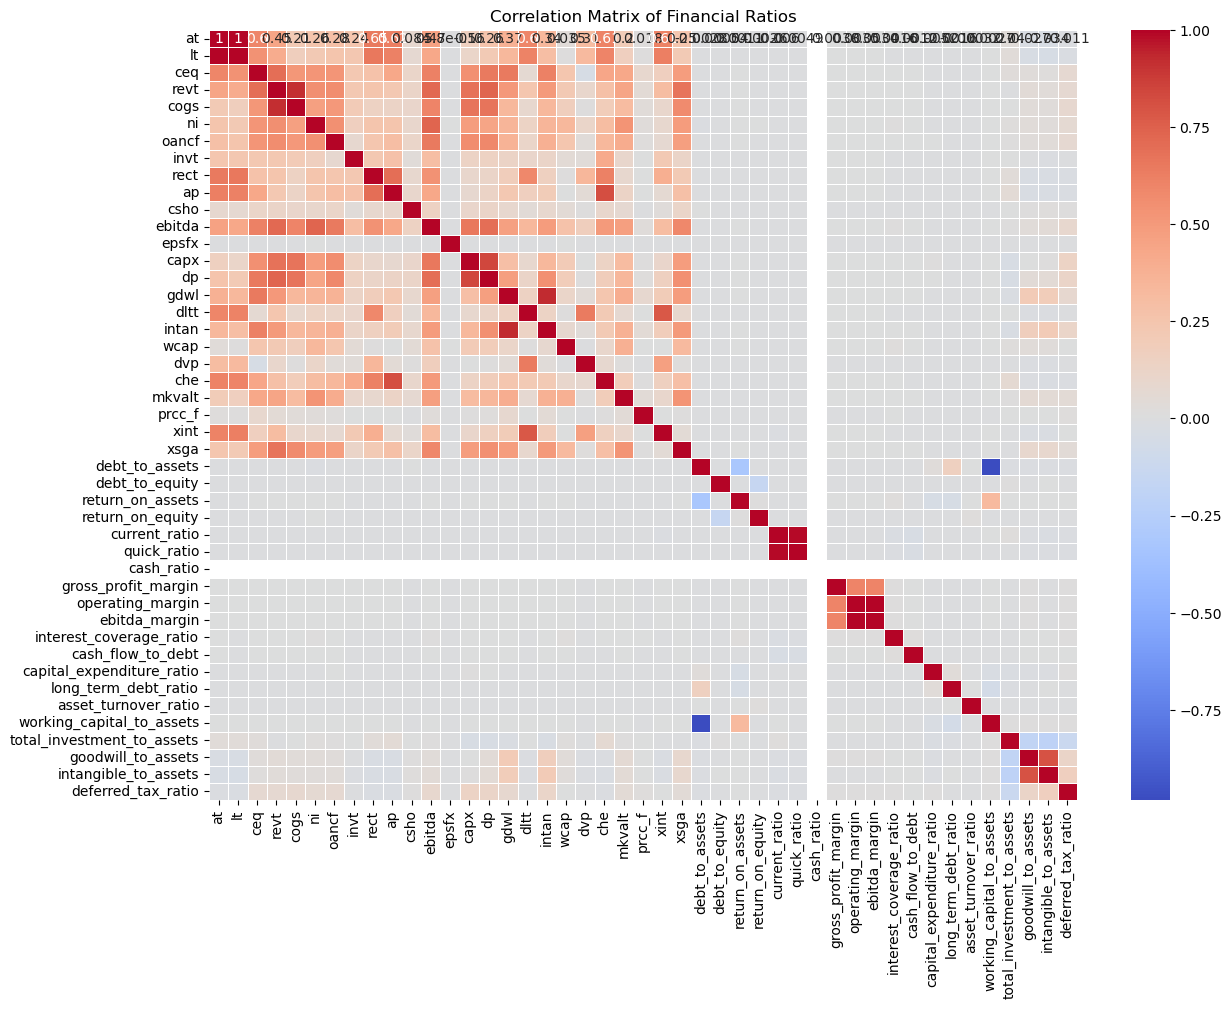

In [4]:
def generate_correlation_matrix(df):
    selected_columns = [
        'debt_to_assets', 'debt_to_equity', 'return_on_assets', 'return_on_equity',
        'current_ratio', 'quick_ratio', 'cash_ratio', 'gross_profit_margin',
        'operating_margin', 'ebitda_margin', 'interest_coverage_ratio',
        'cash_flow_to_debt', 'capital_expenditure_ratio', 'long_term_debt_ratio',
        'asset_turnover_ratio', 'working_capital_to_assets', 'total_investment_to_assets',
        'goodwill_to_assets', 'intangible_to_assets', 'deferred_tax_ratio'
    ]

    all_columns = df.columns
    arr = []
    for i in all_columns:
        if i != "datadate":
            arr.append(i)

    all_columns = arr
    
    correlation_matrix = df[all_columns].corr()

    # Plot heatmap
    plt.figure(figsize=(14, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix of Financial Ratios')
    save_path = os.path.join("", f"Correlation Matrix.png")
    plt.savefig(save_path)
    plt.show()

generate_correlation_matrix(df_selected)

In [5]:
def analyze_correlations(corr_matrix, threshold=0.8):
    high_corr = np.where(np.abs(corr_matrix) > threshold)
    high_corr_list = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y]) 
                      for x, y in zip(*high_corr) if x != y and x < y]
    high_corr_list.sort(key=lambda x: abs(x[2]), reverse=True)
    return high_corr_list


all_columns = df_selected.columns
arr = []
for i in all_columns:
    if i != "datadate":
        arr.append(i)

all_columns = arr
high_correlations = analyze_correlations(df_selected[all_columns].corr(), threshold=0.8)
print("Highly correlated pairs of variables:")
for var1, var2, corr in high_correlations:
    print(f"{var1} and {var2}: {corr:.2f}")

Highly correlated pairs of variables:
operating_margin and ebitda_margin: 1.00
at and lt: 1.00
current_ratio and quick_ratio: 0.99
debt_to_assets and working_capital_to_assets: -0.98
gdwl and intan: 0.92
revt and cogs: 0.92
capx and dp: 0.84
ap and che: 0.82
goodwill_to_assets and intangible_to_assets: 0.80


In [6]:
def nber_recession_analysis(financial_data, recession_data):
    recession_data['DATE'] = pd.to_datetime(recession_data['DATE'])
    recession_periods = recession_data[recession_data['USREC'] == 1].copy()

    financial_data['datadate'] = pd.to_datetime(financial_data['datadate'])

    financial_data['recession_flag'] = financial_data['datadate'].apply(
        lambda date: 1 if any(
            (date.year == rec_date.year) and (date.month == rec_date.month)
            for rec_date in recession_periods['DATE']
        ) else 0
    )


    recession_impact = financial_data.groupby('recession_flag').agg({
        'at': 'mean',      # Average Total Assets
        'lt': 'mean',      # Average Total Liabilities
        'ceq': 'mean',     # Average Common Equity
        'revt': 'mean',    # Average Revenue
        'cogs': 'mean',    # Average Cost of Goods Sold
        'ni': 'mean',      # Average Net Income
        'oancf': 'mean',   # Average Operating Cash Flow
        'invt': 'mean',    # Average Inventory
        'rect': 'mean',    # Average Accounts Receivable
        'ap': 'mean',      # Average Accounts Payable
        'csho': 'mean',    # Average Common Shares Outstanding
        'ebitda': 'mean',  # Average EBITDA
        'epsfx': 'mean',   # Average Earnings Per Share (Diluted)
        'capx': 'mean',    # Average Capital Expenditures
        'dp': 'mean',      # Average Depreciation and Amortization
        'gdwl': 'mean',    # Average Goodwill
        'dltt': 'mean',    # Average Long-Term Debt
        'intan': 'mean',   # Average Intangible Assets
        'wcap': 'mean',    # Average Working Capital
        'dvp': 'mean',     # Average Dividends Payable
        'che': 'mean',     # Average Cash and Cash Equivalents
        'mkvalt': 'mean',  # Average Market Value of Equity
        'prcc_f': 'mean',  # Average Price Close - Fiscal
        'xint': 'mean',    # Average Interest Expense
        'xsga': 'mean'     # Average SG&A Expenses
    }).reset_index()

    recession_impact['Period'] = recession_impact['recession_flag'].map({0: 'Non-Recession', 1: 'Recession'})

    print("Impact of Recessions on Key Financial Metrics:")
    print(recession_impact)

    return financial_data

recession_data = pd.read_csv('nber_recession_data.csv')  # Load NBER recession data with 'DATE' and 'USREC' columns
updated_financial_data = nber_recession_analysis(df_selected, recession_data)
updated_financial_data

Impact of Recessions on Key Financial Metrics:
   recession_flag            at            lt          ceq         revt  \
0               0  11847.392614  10145.629779  1540.629893  2379.521721   
1               1  12193.327805  10744.095453  1283.780905  2525.873763   

          cogs          ni       oancf        invt         rect  ...  \
0  1380.304301  136.084655  292.828589  326.643477  2442.750528  ...   
1  1573.277181   55.085403  309.160074  342.729334  2418.908244  ...   

          dltt       intan        wcap       dvp         che       mkvalt  \
0  2220.792719  662.447316  146.343945  5.585169  856.103885  2092.884247   
1  1839.385817  581.198831  141.192225  2.697315  835.299876  1182.118267   

      prcc_f        xint        xsga         Period  
0  34.585913  128.109036  290.168472  Non-Recession  
1  27.562827  163.420766  321.573422      Recession  

[2 rows x 27 columns]


,datadate,at,lt,ceq,revt,cogs,ni,oancf,invt,rect,...,cash_flow_to_debt,capital_expenditure_ratio,long_term_debt_ratio,asset_turnover_ratio,working_capital_to_assets,total_investment_to_assets,goodwill_to_assets,intangible_to_assets,deferred_tax_ratio,recession_flag
0,1996-05-31,437.846,233.211,204.635,504.990,404.110,16.012,24.760,175.084,107.138,...,0.106170,0.017237,0.270168,1.153351,0.590680,0.075152,0.013343,0.013343,0.070070,0
1,1997-05-31,529.584,260.325,269.259,589.328,468.500,23.025,9.531,217.239,122.944,...,0.036612,0.057200,0.220584,1.112813,0.593143,0.052128,0.010674,0.010674,0.061482,0
2,1998-05-31,670.559,369.709,300.850,782.123,619.434,35.657,22.823,263.425,163.359,...,0.061732,0.026090,0.264718,1.166375,0.476098,0.091184,0.039616,0.039616,0.054954,0
3,1999-05-31,726.630,400.595,326.035,918.036,727.714,41.671,28.525,304.499,164.302,...,0.071207,0.049724,0.249011,1.263416,0.460482,0.056677,0.055177,0.055177,0.061751,0
4,2000-05-31,740.998,401.483,339.515,1024.333,833.107,35.163,10.051,336.018,128.348,...,0.025035,0.030154,0.243519,1.382369,0.468896,0.057097,0.052416,0.052416,0.075601,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296595,2022-12-31,2058.061,1342.548,646.557,212.978,42.103,85.742,118.234,0.991,5.760,...,0.088067,0.171767,0.465850,0.103485,-0.064746,0.001669,0.000000,0.004040,0.000000,0
296596,2021-12-31,46650.099,10793.531,35687.306,12924.885,4445.511,1882.199,1836.160,1287.749,5179.432,...,0.170117,0.006618,0.002525,0.277060,0.029404,0.000000,0.239354,0.789382,0.097443,0
296597,2022-12-31,41948.594,22119.555,19677.222,13082.804,4629.226,1277.194,2485.709,1624.205,2254.368,...,0.112376,0.008732,0.287319,0.311877,-0.008933,0.003791,0.241160,0.816774,0.103432,0
296598,2021-12-31,686.085,379.035,288.849,756.466,377.304,138.508,163.283,154.754,205.966,...,0.430786,0.042057,0.029887,1.102583,0.161409,0.000000,0.010179,0.015663,0.023758,0


In [13]:
def scale_features(financial_data):

    metrics_to_scale = [
        'at', 'lt', 'ceq', 'revt', 'cogs', 'ni', 'oancf', 'invt', 'rect', 'ap',
        'csho', 'ebitda', 'epsfx', 'capx', 'dp', 'gdwl', 'dltt', 'intan', 
        'wcap', 'dvp', 'che', 'mkvalt', 'prcc_f', 'xint', 'xsga'
    ]
    
    features = financial_data[metrics_to_scale]
    
    standard_scaler = StandardScaler()
    features_standard_scaled = pd.DataFrame(standard_scaler.fit_transform(features), columns=metrics_to_scale)
    #return features_standard_scaled

    scaled_data = financial_data.copy()
    scaled_data[[f'{col}' for col in metrics_to_scale]] = features_standard_scaled
    return scaled_data

scaled_financial_data = scale_features(updated_financial_data)
scaled_financial_data.head()

,datadate,at,lt,ceq,revt,cogs,ni,oancf,invt,rect,...,cash_flow_to_debt,capital_expenditure_ratio,long_term_debt_ratio,asset_turnover_ratio,working_capital_to_assets,total_investment_to_assets,goodwill_to_assets,intangible_to_assets,deferred_tax_ratio,recession_flag
0,1996-05-31,-0.106368,-0.098482,-0.144916,-0.147239,-0.108658,-0.089072,-0.106377,-0.024776,-0.059091,...,0.106170,0.017237,0.270168,1.153351,0.590680,0.075152,0.013343,0.013343,0.070070,0
1,1997-05-31,-0.105514,-0.098213,-0.137838,-0.140641,-0.101561,-0.083689,-0.112402,-0.017921,-0.058691,...,0.036612,0.057200,0.220584,1.112813,0.593143,0.052128,0.010674,0.010674,0.061482,0
2,1998-05-31,-0.104201,-0.097130,-0.134378,-0.125556,-0.084925,-0.073992,-0.107143,-0.010410,-0.057668,...,0.061732,0.026090,0.264718,1.166375,0.476098,0.091184,0.039616,0.039616,0.054954,0
3,1999-05-31,-0.103679,-0.096824,-0.131620,-0.114921,-0.072990,-0.069376,-0.104887,-0.003731,-0.057644,...,0.071207,0.049724,0.249011,1.263416,0.460482,0.056677,0.055177,0.055177,0.061751,0
4,2000-05-31,-0.103546,-0.096815,-0.130144,-0.106604,-0.061373,-0.074372,-0.112196,0.001394,-0.058554,...,0.025035,0.030154,0.243519,1.382369,0.468896,0.057097,0.052416,0.052416,0.075601,0


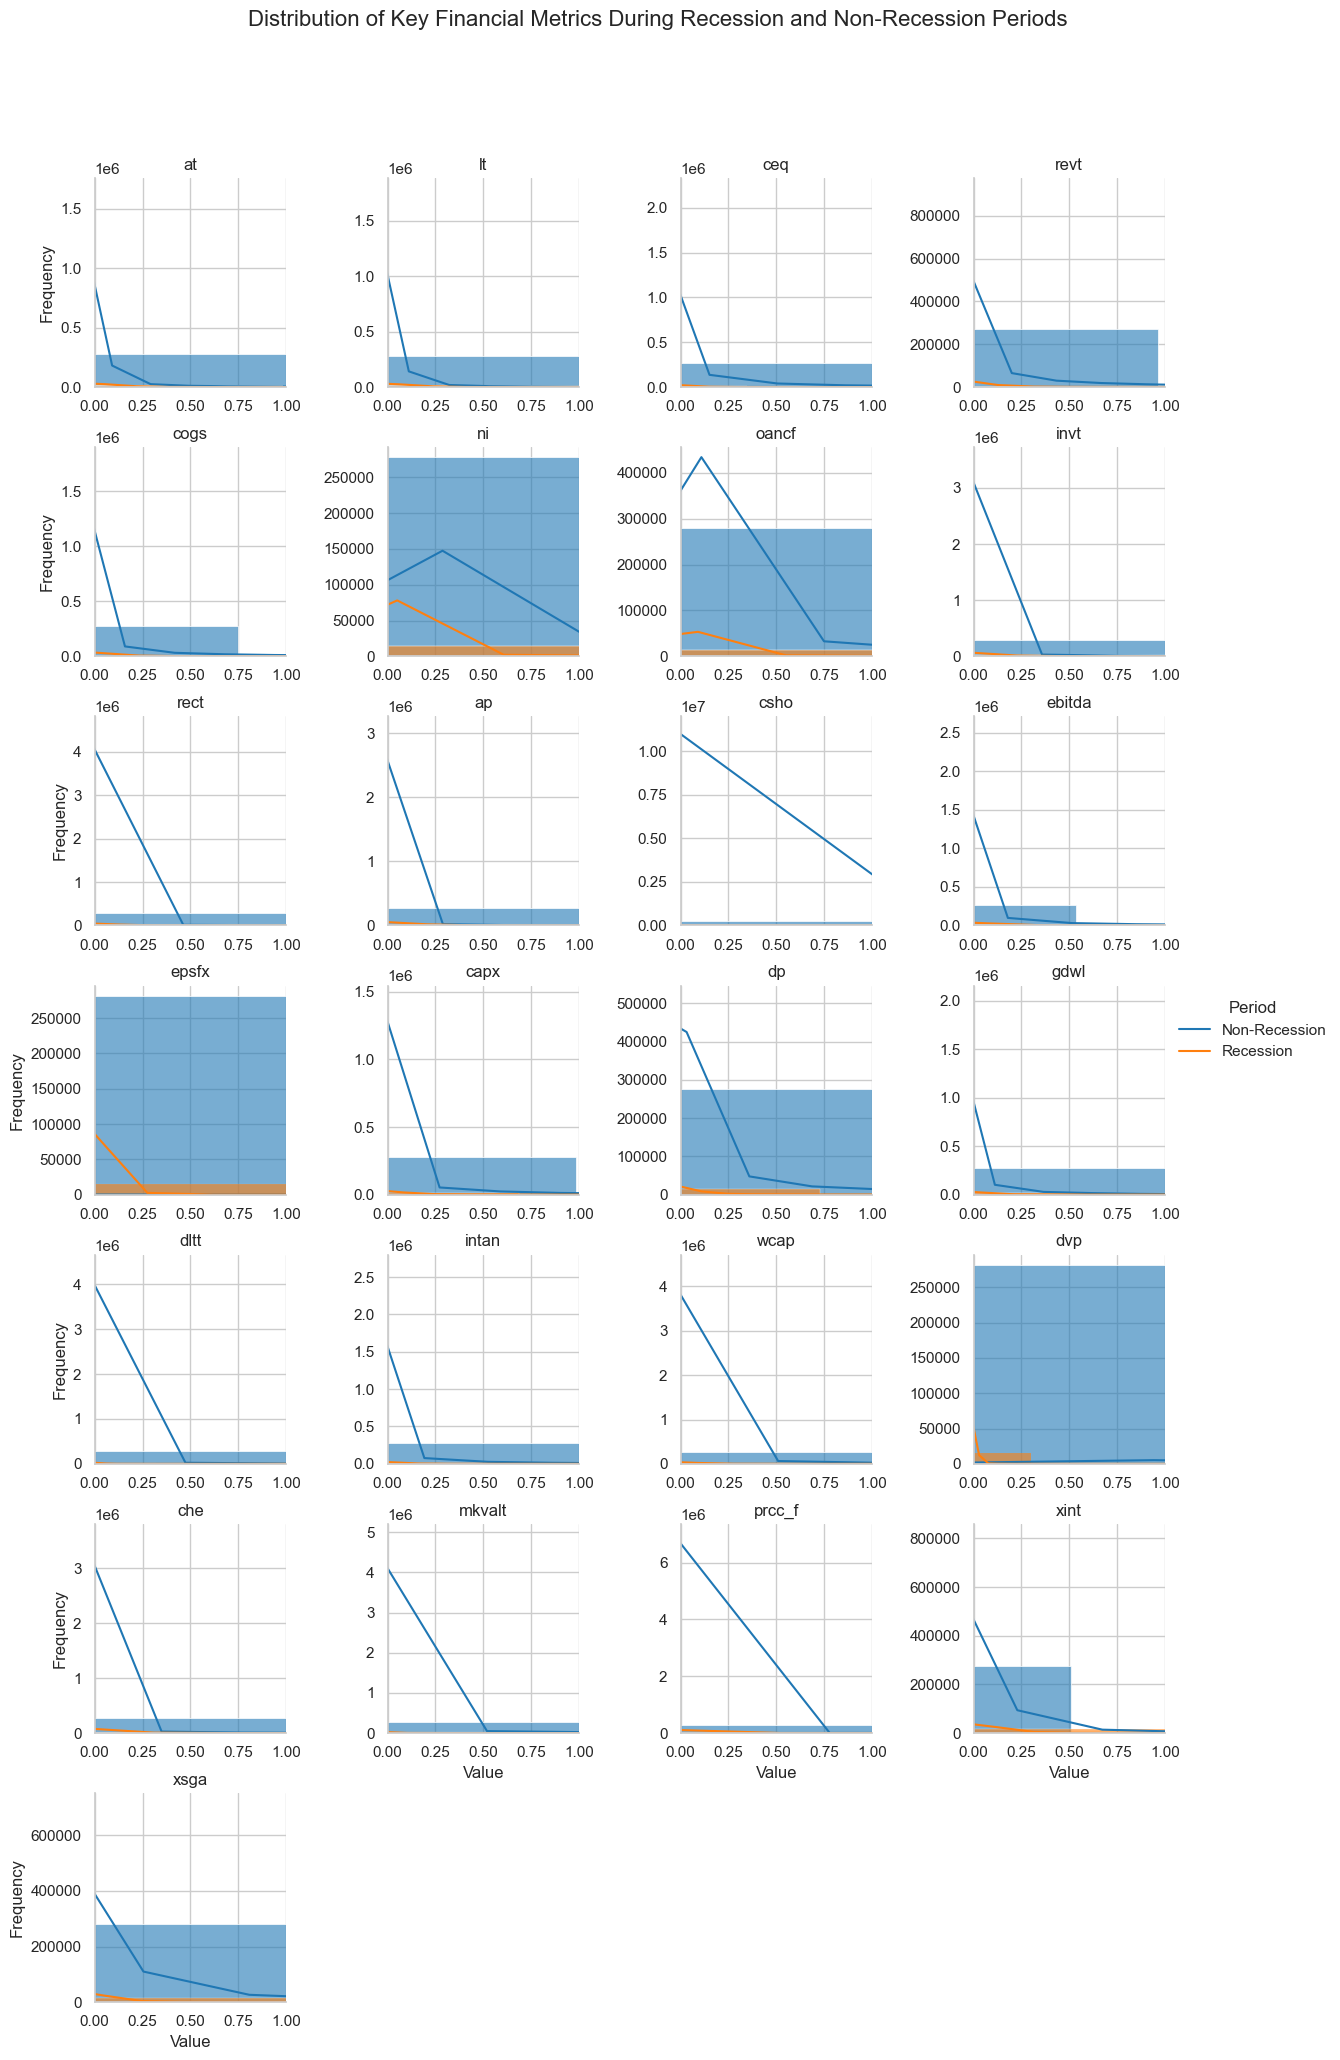

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_faceted_histograms(financial_data):

    metrics = [
        'at', 'lt', 'ceq', 'revt', 'cogs', 'ni', 'oancf', 'invt', 'rect', 'ap',
        'csho', 'ebitda', 'epsfx', 'capx', 'dp', 'gdwl', 'dltt', 'intan', 
        'wcap', 'dvp', 'che', 'mkvalt', 'prcc_f', 'xint', 'xsga'
    ]

    sns.set(style="whitegrid")

    g = sns.FacetGrid(financial_data.melt(id_vars=['recession_flag'], value_vars=metrics), 
                      col='variable', hue='recession_flag', col_wrap=4, sharex=False, sharey=False, 
                      palette=['#1f77b4', '#ff7f0e'])

    g.map(sns.histplot, 'value', kde=True, bins=30, alpha=0.6)

    g.add_legend(title="Period", labels=["Non-Recession", "Recession"])
    g.set_titles("{col_name}")
    g.set_axis_labels("Value", "Frequency")

    g.set(xlim=(0, 1))

    plt.subplots_adjust(top=0.9)
    g.fig.suptitle('Distribution of Key Financial Metrics During Recession and Non-Recession Periods', fontsize=16)


    save_path = os.path.join("", "Histogram.png")
    plt.savefig(save_path)
    plt.show()

plot_faceted_histograms(scaled_financial_data)


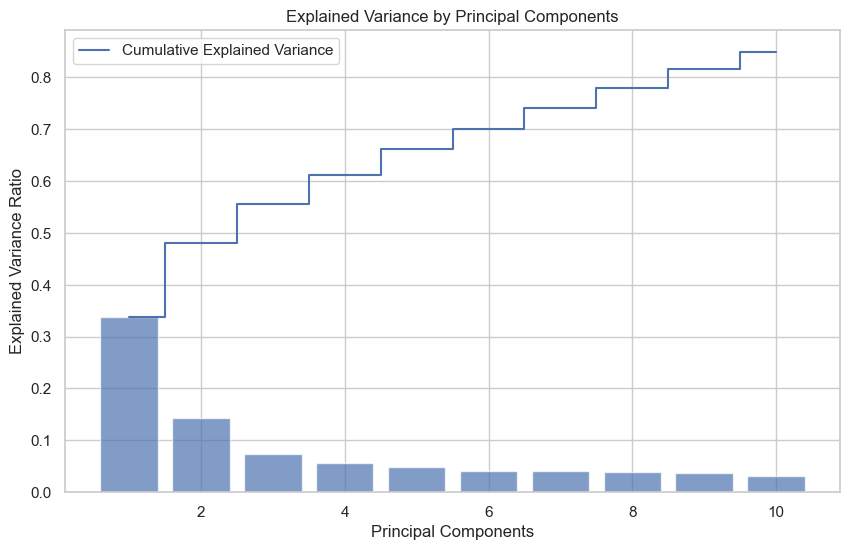

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,recession_flag
0,-0.472682,0.043025,-0.030188,0.084685,0.068063,0.019149,-0.011592,-0.022866,0.018710,-0.026263,0
1,-0.454382,0.030297,-0.027463,0.098420,0.079003,0.030778,-0.018318,-0.020141,0.029035,-0.040940,0
2,-0.433988,0.023942,-0.025205,0.099610,0.079007,0.027670,-0.016545,-0.022004,0.037542,-0.037678,0
3,-0.408605,0.007987,-0.019478,0.107677,0.088669,0.025773,-0.015706,-0.030097,0.047072,-0.040627,0
4,-0.408796,0.009414,-0.017666,0.108431,0.084576,0.024165,-0.014844,-0.036064,0.057105,-0.046806,0


In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

def perform_pca(financial_data, n_components=10):

    metrics_to_scale = [
        'at', 'lt', 'ceq', 'revt', 'cogs', 'ni', 'oancf', 'invt', 'rect', 'ap',
        'csho', 'ebitda', 'epsfx', 'capx', 'dp', 'gdwl', 'dltt', 'intan', 
        'wcap', 'dvp', 'che', 'mkvalt', 'prcc_f', 'xint', 'xsga'
    ]

    #metrics_to_scale = financial_data.columns
    scaled_features = financial_data[[f'{col}' for col in metrics_to_scale]]

    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(scaled_features)

    pca_columns = [f'PC{i+1}' for i in range(n_components)]
    pca_data = pd.DataFrame(principal_components, columns=pca_columns)

    pca_data['recession_flag'] = financial_data['recession_flag']

    plt.figure(figsize=(10, 6))
    plt.bar(range(1, n_components + 1), pca.explained_variance_ratio_, alpha=0.7, align='center')
    plt.step(range(1, n_components + 1), pca.explained_variance_ratio_.cumsum(), where='mid', label='Cumulative Explained Variance')
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance by Principal Components')
    plt.legend(loc='best')
    plt.grid(True)
    save_path = os.path.join("", "PCA.png")
    plt.savefig(save_path)
    plt.show()

    return pca_data, pca

pca_financial_data, pca_model = perform_pca(scaled_financial_data, n_components=10)
pca_financial_data.head()